# ANITA Lecture on Gaussian Process Modeling

Requirements for this notebook:
* python
* jupyter
* numpy
* scipy
* random
* matplotlib
* scikit-learn

## Parameteric models

A parameteric model is one which has a finite (and fixed) number of parameters that represent some unknown quantities inside the model. For example, a physical model such as the Friedmann equation contains parameters such as the Hubble parameter today $H_0$, and the density of matter relative to the critical density $\Omega_m$. Of course, even simple and somewhat unphysical models, such as scaling relations, still have parameters. We briefly consider two such models.

### Linear Models

In a linear model, the data can be described through a linear relation, for example $y = mx+ c$
Here $x$ is some **independent variable** that we measure, and $y$ is some **dependent variable** that we want to model

We will start with an example where we generate 10 random points in the range $x=0\dots 1$.

In [45]:
import random
from matplotlib import pyplot as plt
import numpy as np

First we define some external function, which we will be fitting to, but also using to generate the mock data

In [46]:
def model(x_in,params):
    """output a value y for a given input x"""
    y = params[0]*x_in + params[1]
    return y

Then we randomly pick the values of the input parameters for the model

In [47]:
random.seed()

n_params = 2
params = np.zeros(n_params)
for i in range(0,n_params):
    params[i] = random.uniform(0,1)

Then we randomly generate the $x$-values for each of the data points, and use our model to calculate the assoicated $y$-values, with a 2% Gaussian scatter around the mean for each data point

In [48]:
n_points=10
x_data = np.zeros(n_points)
y_data = np.zeros(n_points)
y_sigma = np.zeros(n_points)
for i in range(0,n_points):
    x_data[i] = random.uniform(0,1)
    sigma=0.02
    y_data[i] = model(x_data[i],params)+random.gauss(0,sigma)
    y_sigma[i] = sigma

Now we plot it

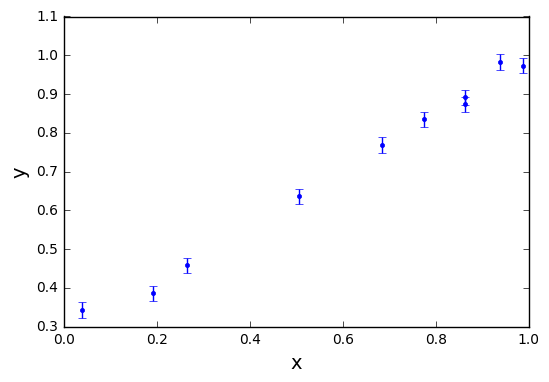

In [49]:
# make sure figures appear inline in Ipython Notebook
%matplotlib inline
plt.subplot(1,1,1)
lab_fontsize = 14
h0 = plt.errorbar(x_data,y_data,yerr=y_sigma,linestyle='None',marker='.')
plt.xlim([0,1.])
plt.xlabel('x',fontsize=lab_fontsize)
plt.ylabel('y',fontsize=lab_fontsize)

Now we can do ordinary [linear least-squares](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html) fitting to recover the best fit parameters (gradient *m* and intercept *c*) from the data. As we know from linear algebra, we can rewrite the equation as a matrix multiplication
\begin{equation}
\mathbf{y} = \mathbf{A}\cdot\mathbf{p} \,,
\end{equation}
where $\mathbf{y}$ is a vector containing the measured dependent variable values, A is a matrix containing the indepedent variable values, in the form $A=\{\mathbf{x},1\}$, and $p = \{m,c\}$ are the model parameters. We then solve for the parameter values.

In [50]:
A = np.vstack([x_data, np.ones(len(x_data))]).T
w, resid, n, s = np.linalg.lstsq(A,y_data)

How to they compare?

In [51]:
print "True parameter values m=%f c=%f"%(params[0],params[1])
print "Linear least squares fit values m=%f c=%f"%(w[0],w[1])

True parameter values m=0.720126 c=0.266752
Linear least squares fit values m=0.711662 c=0.279400


They are different (due to the dispersion of the data), but not **too** different. If the data set was larger ($n=100$ or $n=1000$) we would expect to recover the parameter values exactly.

How does the recovered model compare against the data that we have, and the true model that generated it?

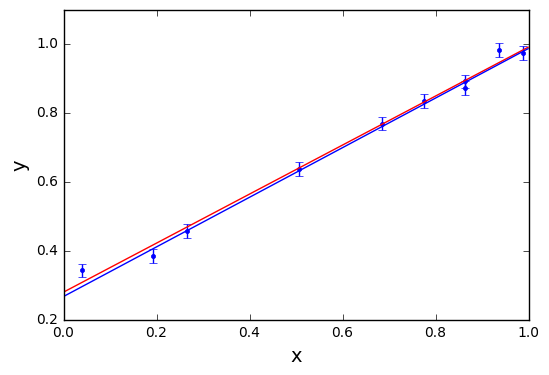

In [52]:
x_out=np.arange(0,1.,0.001)
y_out=[]
y_true=[]
for i in range(0,1000):
    y_out.append(model(x_out[i],w))
    y_true.append(model(x_out[i],params))
    
# make sure figures appear inline in Ipython Notebook
%matplotlib inline
plt.subplot(1,1,1)
lab_fontsize = 14
h0 = plt.errorbar(x_data,y_data,yerr=y_sigma,linestyle='None',marker='.')
h1 = plt.plot(x_out,y_out,'-r')
h2 = plt.plot(x_out,y_true,'-b')
plt.xlim([0,1.])
plt.xlabel('x',fontsize=lab_fontsize)
plt.ylabel('y',fontsize=lab_fontsize)

The agreement between the true model and the recovered model is good in the middle of the data, but they start to diverge at the extremes.

#### Error propagation

Notice that the linear least-squares fit does not make any use of the error bars on the data. (In fact it assumes homoscedastic error bars for all data points, but does not refer to the values.) So there is no mechanism for propagating the measurement error into some uncertainty in the parameters of the model. For example, suppose $x$ was redshift, and $y$ was star-formation rate. We could imagine using the star-formation history of the Universe to inputs for a model of supernova rate (as a function of redshift). We would want to be able to propagate the measurement errors on the star-formation history forward to some uncertainity on the estimated SN rate. 

One approach would be to drawn random replacment data, based on the distribution given by the error bars, and see how the model parameters change (this is [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)). A Bayesian alternative would be to draw alternative model parameters from their probability distribution of parameter values (in our case the posterior probability of $m$ and $c$, which is written as $P(m,c|D)$).

Normally we would have to sample the posterior, for example using methods such as [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo). But for a linear model such as this, the posterior probability distribution is a [Multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution), with an analytic solution for the covariance matrix given by the inverse of the Fisher information matrix. 

In [53]:
# Code for determining to covariance matrix of a linear model

import numpy as np

def fisher(n_model,x_data,sigma_data):
    '''Function that determines the Fisher information matrix for a linear model'''

    n_data = len(x_data)
    fisher_sum = np.zeros([n_model,n_model])
    for i_data in range(0,n_data):
        x = x_data[i_data]
        partial = comp_partial(x,n_model)
        for i in range(0,n_model):
            for j in range(0,n_model):
                fisher_sum[i,j] += (partial[i]*partial[j])/sigma_data[i_data]**2

    return fisher_sum

def comp_partial(x_in,n):
    '''Function that determines the partial derivatives of the likelihood
    with respect to the parameters.
    '''
    partial_out = np.zeros(n)
    for i in range(0,n):
        partial_out[i] = x_in**i

    return partial_out

def covariance(n_model,x_data,sigma_data):
    '''Function that predicts the covariance matrix for a linear model'''

    f = fisher(n_model,x_data,sigma_data)
    f = np.asmatrix(f)
    c = f.getI()

    return c

We now insert the data to estimate the covariance matrix.

In [54]:
c_out = covariance(2,x_data,y_sigma)
print c_out

[[ 0.00018365 -0.00023493]
 [-0.00023493  0.00038423]]


The equation for a multivariate normal distribution is 

\begin{equation}
f(\bf{x}) = \frac{1}{\sqrt{|2\pi\Sigma|}} \exp\left(-(\bf{\mu}-\bf{x})^T \Sigma^{-1}(\bf{\mu}-\bf{x})\right)
\end{equation}

For the covariance matrix $\Sigma$ we use the values given above, and for the mean $\mu$, we use the recovered parameters from the linear least-squares fit. We now generate 100 random models from the posterior, and plot them over the data.

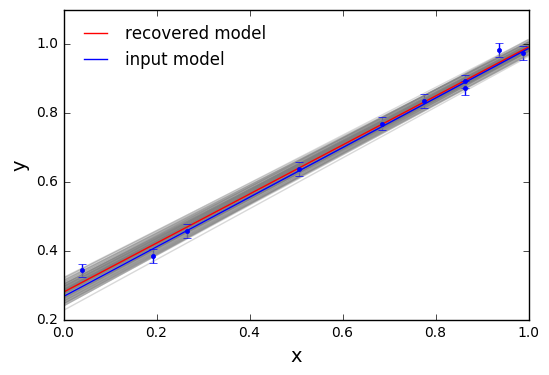

In [55]:
# make sure figures appear inline in Ipython Notebook
%matplotlib inline
ax = plt.subplot(1,1,1)
lab_fontsize = 14


for i in range(0,100):
    new_params = np.random.multivariate_normal(w,c_out)
    h_new = plt.plot(x_out,new_params[0]*x_out+new_params[1],color='#808080',alpha=0.3)

h1 = plt.plot(x_out,y_out,'-r',label='recovered model')
h2 = plt.plot(x_out,y_true,'-b',label='input model')
h0 = plt.errorbar(x_data,y_data,yerr=y_sigma,linestyle='None',marker='.')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles,frameon=False,loc=2)
plt.xlim([0,1.])
plt.xlabel('x',fontsize=lab_fontsize)
plt.ylabel('y',fontsize=lab_fontsize)

This 'family' of linear fits are all relativley good fits to the data, and represent the underlying uncertainty on the parameter values. We can take these parameter errors forward to any new measurment we infer using this data.

### Higher dimensional models

What do I do if my model is not linear?

Let us consider a 5-dimensional polynomial model, $y = ax^4 + bx^3 + cx^2 + dx +e$.

In [56]:
def poly_model(x_in,params):
    """output a value y for a given input x"""
    y = params[0]*x_in**4 + params[1]*x_in**3+params[2]*x_in**2+params[3]*x_in+params[4]
    return y

Once again we generate new values for the parameters of the model

In [57]:
random.seed()

n_params = 5
params = np.zeros(n_params)
for i in range(0,n_params):
    params[i] = random.uniform(0,1)

And once again we generate 10 random data points, in the range $x=0 \ldots 1$

In [58]:
n_points=10
x_poly = np.zeros(n_points)
y_poly = np.zeros(n_points)
y_poly_sigma = np.zeros(n_points)
for i in range(0,n_points):
    x_poly[i] = random.uniform(0,1)
    sigma=0.02
    y_poly[i] = poly_model(x_poly[i],params)+random.gauss(0,sigma)
    y_poly_sigma[i] = sigma

And we plot them.

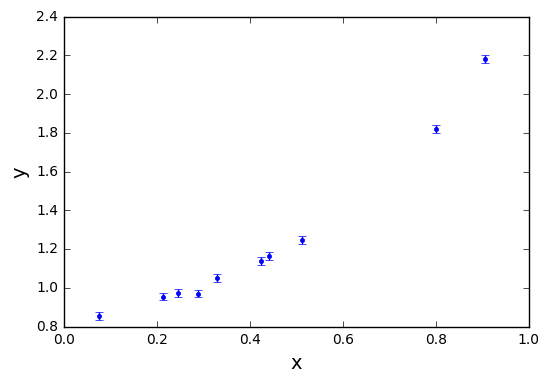

In [59]:
# make sure figures appear inline in Ipython Notebook
%matplotlib inline
plt.subplot(1,1,1)
lab_fontsize = 14
h0 = plt.errorbar(x_poly,y_poly,yerr=y_poly_sigma,linestyle='None',marker='.')
plt.xlim([0,1.])

plt.xlabel('x',fontsize=lab_fontsize)
plt.ylabel('y',fontsize=lab_fontsize)

If we know the order of the polynomial, we do least-squares fitting, but for a polynomial. The new linear algebra equation becomes
\begin{equation}
\left( \begin{array}{ccc}
y_0 \\
y_1  \\
\vdots \\
y_n  \end{array} \right) =
\left( \begin{array}{ccc}
x_0^n & x_0^{n-1} & \ldots & 1 \\
x_1 & x_1^{n-1} & \ldots & 1  \\
\vdots & \vdots & \vdots & \vdots  \\
x_n^n & x_n^{n-1} & \ldots & 1  \end{array} \right)
\left( \begin{array}{ccc}
p_0 \\
p_1  \\
\vdots \\
p_n  \end{array} \right)
\end{equation}

In python, we can use [polyfit](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) to fit for the coefficients.

In [60]:
z_poly, c_poly = np.polyfit(x_poly, y_poly, 4, cov=True)

How do the coefficients compare?

In [61]:
for i in range(0,5):
    print "True value of parameter %d = %f, recovered value = %f"%(i,params[i],z_poly[i])

True value of parameter 0 = 0.027157, recovered value = 2.055326
True value of parameter 1 = 0.918816, recovered value = -2.267635
True value of parameter 2 = 0.209845, recovered value = 1.750443
True value of parameter 3 = 0.550412, recovered value = 0.239065
True value of parameter 4 = 0.787070, recovered value = 0.827518


As you can see, the recovered parameters are once again very different to the input parameters. How does the recovered function compare when plotted against the data and the input function?

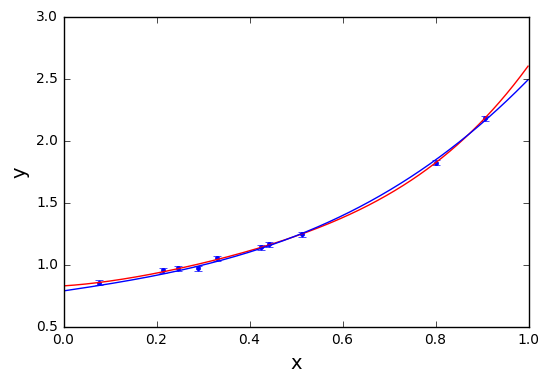

In [62]:
x_out_poly=np.arange(0,1.,0.001)
y_out_poly=[]
y_out_poly_true=[]
for i in range(0,1000):
    y_out_poly.append(poly_model(x_out_poly[i],z_poly))
    y_out_poly_true.append(poly_model(x_out_poly[i],params))
    
# make sure figures appear inline in Ipython Notebook
%matplotlib inline
plt.subplot(1,1,1)
lab_fontsize = 14
h0 = plt.errorbar(x_poly,y_poly,yerr=y_poly_sigma,linestyle='None',marker='.')
h1 = plt.plot(x_out_poly,y_out_poly,'-r')
h2 = plt.plot(x_out_poly,y_out_poly_true,'-b')
plt.xlim([0,1.])

plt.xlabel('x',fontsize=lab_fontsize)
plt.ylabel('y',fontsize=lab_fontsize)

Even though the recovered parameter values are very different, the model still gives a similar fit to the data across the input data range. However, it will quickly diverge outside of the input data range.

We can also apply the error propagation machinery we developed in the linear model to this polynomial model, as it generalises for any order polynomial. This time we use the covariance matrix given to us by the *polyfit* function.

In [63]:
print c_poly

[[  5.62328032e+00  -1.06530538e+01   6.60553645e+00  -1.50600274e+00
    9.45987549e-02]
 [ -1.06530538e+01   2.05349762e+01  -1.30146104e+01   3.04239049e+00
   -1.97026345e-01]
 [  6.60553645e+00  -1.30146104e+01   8.48234594e+00  -2.05096374e+00
    1.38926846e-01]
 [ -1.50600274e+00   3.04239049e+00  -2.05096374e+00   5.19443396e-01
   -3.78364123e-02]
 [  9.45987549e-02  -1.97026345e-01   1.38926846e-01  -3.78364123e-02
    3.17693328e-03]]


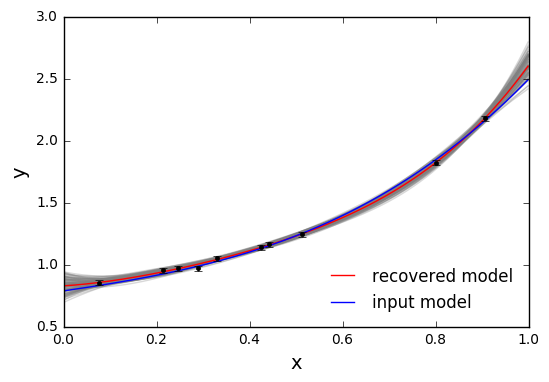

In [64]:
# make sure figures appear inline in Ipython Notebook
%matplotlib inline
ax=plt.subplot(1,1,1)
lab_fontsize = 14

for i in range(0,100):
    new_poly = np.random.multivariate_normal(z_poly,c_poly)
    p_func = np.poly1d(new_poly)
    h_new = plt.plot(x_out_poly,p_func(x_out),color='#808080',alpha=0.3)

h1 = plt.plot(x_out_poly,y_out_poly,'-r',label='recovered model')
h2 = plt.plot(x_out_poly,y_out_poly_true,'-b',label='input model')
h0 = plt.errorbar(x_poly,y_poly,yerr=y_poly_sigma,linestyle='None',marker='.',color='k')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles,frameon=False,loc=4)
plt.xlim([0,1.])

plt.xlabel('x',fontsize=lab_fontsize)
plt.ylabel('y',fontsize=lab_fontsize)

We see that the family of curves allowed by the data pass through all of the data points, but then rapidly diverges outside of the measured data range.

## Non-parametric models

When people talk about non-parametric models, they really mean models where the number of parameters can grow with the number of data points (i.e. 'infinite parametric' models). We will start with the classic example of interpolation in one-dimension, which is cubic spline, before moving on to Gaussian Process Regression.

### Cubic spline

We will start with a very complex model for the data, that cannot be represented by a simple polynomial.

In [31]:
import math
def model_complex(x_in,params):
    """output a value y for a given input x"""
    n=len(params)
    y = 0.
    for i in range(0,n):
      if math.fmod(i,2) == 0:
        y = y + params[i]*math.sin(float(i)*x_in+params[i+1])
      else:
        y = y

    return y

We once again generate the parameter values randomly, though this model will have 10 input parameters. For the sake of simplicity, this time we will not add any dispersion to the data.

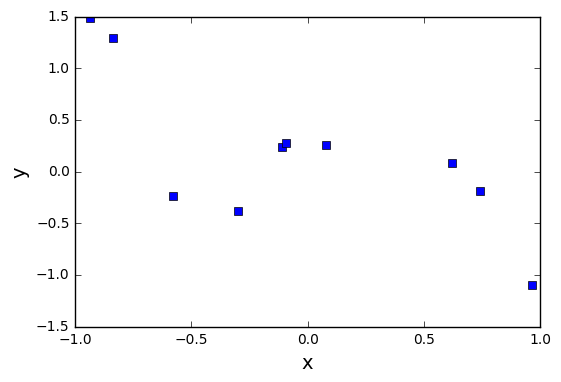

In [32]:
random.seed()

n_params = 10
params = np.zeros(n_params)
for i in range(0,n_params):
    params[i] = random.uniform(-1,1)

n_points=10
x_complex = np.zeros(n_points)
y_complex = np.zeros(n_points)
for i in range(0,n_points):
    x_complex[i] = random.uniform(-1,1)
    y_complex[i] = model_complex(x_complex[i],params)

# make sure figures appear inline in Ipython Notebook
%matplotlib inline
plt.subplot(1,1,1)

h0 = plt.plot(x_complex,y_complex,linestyle='None',marker='s')
lab_fontsize = 14
plt.ylabel('y',fontsize=lab_fontsize)
plt.xlabel('x',fontsize=lab_fontsize)

We see two inflection points (by eye), so we can try fitting this data, with (for example) a third-order polynomial, just to see what happens.

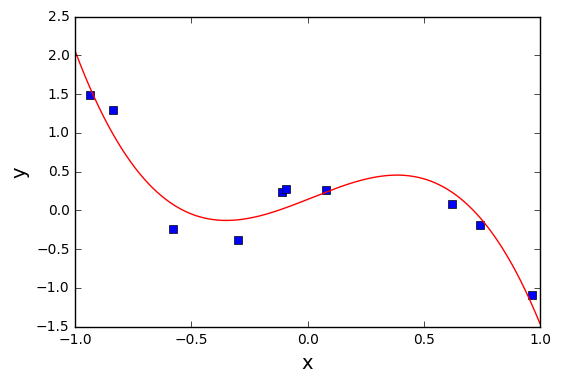

In [34]:
z = np.polyfit(x_complex, y_complex, 3)

p = np.poly1d(z)
x_out_complex=np.arange(-1,1.,0.001)
y_out_complex=[]
for i in range(0,len(x_out_complex)):
    y_out_complex.append(p(x_out_complex[i]))

# make sure figures appear inline in Ipython Notebook
%matplotlib inline
plt.subplot(1,1,1)

h0 = plt.plot(x_complex,y_complex,linestyle='None',marker='s')
h1 = plt.plot(x_out_complex,y_out_complex,'-r')

plt.ylabel('y',fontsize=lab_fontsize)
plt.xlabel('x',fontsize=lab_fontsize)

While we manage to get fairly close to some of the data points, the third-order polynomial misses the others.

How would it perform if we fitted to a higher-order polynomial? We have 10 data points, so we could increase to the maximum, which is 10.

/Users/uqdpark7/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


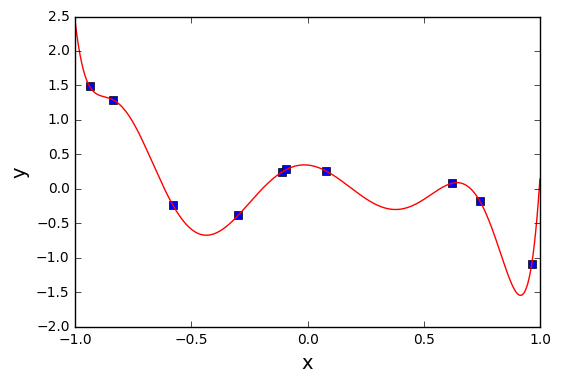

In [35]:
z = np.polyfit(x_complex, y_complex, 10)

p_10 = np.poly1d(z)
y_out_p_10=[]
for i in range(0,len(x_out_complex)):
    y_out_p_10.append(p_10(x_out_complex[i]))

# make sure figures appear inline in Ipython Notebook
%matplotlib inline
plt.subplot(1,1,1)

h0 = plt.plot(x_complex,y_complex,linestyle='None',marker='s')
h1 = plt.plot(x_out_complex,y_out_p_10,'-r')

plt.ylabel('y',fontsize=lab_fontsize)
plt.xlabel('x',fontsize=lab_fontsize)

Here we get a warning because we are trying to fit 10 parameters with 10 data points. But the curve does pass through all the data points.

Instead, if we really don't care about what model we are using, and are happy for it to increase in dimensionality with the number of data points, we can use [cubic spline](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) here to interpolate between the data points. 

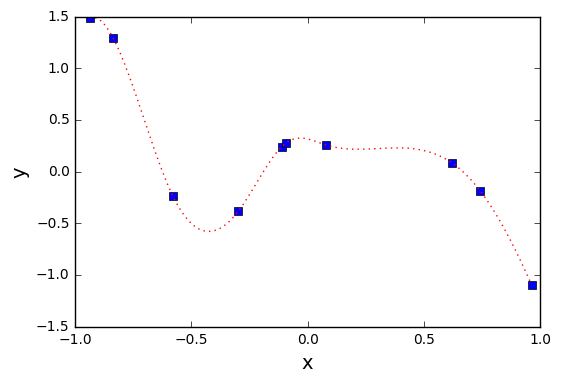

In [36]:
import scipy.interpolate

f = scipy.interpolate.interp1d(x_complex,y_complex,kind='cubic')
y_out_interp =[]
x_out_complex = np.arange(min(x_complex),max(x_complex),0.01)
for i in range(0,len(x_out_complex)):
    y_out_interp.append(f(x_out_complex[i]))

# make sure figures appear inline in Ipython Notebook
%matplotlib inline
plt.subplot(1,1,1)

h0 = plt.plot(x_complex,y_complex,linestyle='None',marker='s')
#h1 = plt.plot(x_out_complex,y_out_complex,'-r')
h2 = plt.plot(x_out_complex,y_out_interp,':r')
plt.ylabel('y',fontsize=lab_fontsize)
plt.xlabel('x',fontsize=lab_fontsize)

This goes through all the data points sucessfully, and is very smooth. Notice also that it doesn't contain some of the oscillatory features that the 10th order polynomial does.

This disadvantage of cubic spline is that we cannot make a prediction outside of the range given by the range of $x$ values, and there is no common way to propagate any measurment errors we have forward to the predictions between the specific x-values. 

### Gaussian Process Regression

Now we turn to Gaussian Processes in python. We make use of the implementation in the [scikit-learn](http://scikit-learn.org/stable/documentation.html) package.

We start by initialising the type of GP we will be using.

In [37]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

kernel = kernels.RBF(length_scale=2.0, length_scale_bounds=(0.1, 10.0))

gp = GaussianProcessRegressor(kernel=kernel)

Here the kernel describes the covariance function. Here we have picked a Radial Basis Function, with form

\begin{equation}
\rm{cov}(f(x_i),f(x_j))=k(x_i,x_j)=\exp\left(-\frac12|x_i-x_j|^2\right)
\end{equation}

In [Rasmussen and Williams](http://www.gaussianprocess.org/gpml/) they refer to this the *squared exponential* covariance function, but it is the same.

In [38]:
xprime = np.atleast_2d(x_complex).T
yprime = np.atleast_2d(y_complex).T
gp.fit(xprime, yprime)
xplot_prime = np.atleast_2d(x_out_complex).T
y_pred, sigma = gp.predict(x_out_complex[:, np.newaxis], return_std=True)

The array containing the predicted values for $y$ from the Gaussian Process will be two dimensional, which isn't helpful for us, so we need to [flatten](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flatten.html) it.

In [39]:
y_pred = y_pred.flatten()

Now we can plot the prediction from the GP (which is much the same as the cubic spline prediction), with the precited 1-sigma error ranges for $y$.

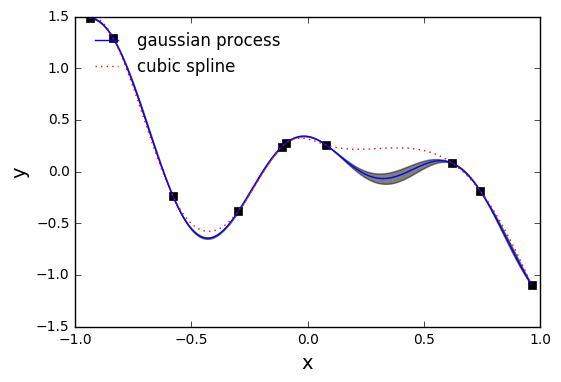

In [40]:
# make sure figures appear inline in Ipython Notebook
%matplotlib inline
ax = plt.subplot(1,1,1)

h0 = plt.plot(x_complex,y_complex,linestyle='None',marker='s',color='black')
h1 = plt.plot(x_out_complex,y_pred,label='gaussian process')
plt.fill_between(x_out_complex, y_pred - sigma, y_pred + sigma,alpha=0.5, color='k')
h2 = plt.plot(x_out_complex,y_out_interp,':r',label='cubic spline')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles,frameon=False,loc=2)
plt.ylabel('y',fontsize=lab_fontsize)
plt.xlabel('x',fontsize=lab_fontsize)

#### Choice of kernel

There are a number of different kernels that can be chosen. Scikit-learn has the following implemented

* RBF
\begin{equation}
k_{\rm RBF}(r)=\exp\left(-\frac{r^2}{2\ell^2}\right)
\end{equation}

* Matern

\begin{equation}
k_{\rm{Matern}}(r)=\frac{2^{1-\nu}}{\Gamma(\nu)}\left(\frac{\sqrt{2\nu}r}{\ell}\right)K_\nu\left(\frac{\sqrt{2\nu}r}{\ell}\right) \,,
\end{equation}
with positive $\nu$ and $\ell$, and $K_\nu$ is a modified Bessel function.

* RationalQuadratic

\begin{equation}
k_{\rm RQ}(r)=\left(1+\frac{r^2}{2\alpha\ell^2}\right)
\end{equation}
with $\alpha$, $\ell>0$.

* ExpSineSquared
\begin{equation}
k_{\rm ESS}(r)=\exp\left(-\frac{2\sin^2(r)}{\ell^2}\right)\,,
\end{equation}
which is the same as the RBF kernel, except the one-dimensional input variable $r$ is mapped to the two-dimensional $u(r) = (cos(r),sin(r))$

* DotProduct
\begin{equation}
k_{\rm{DP}}(x,x') = (x\cdot x')^p
\end{equation}
This is equivalent to linear ($p=1$) or polynomial ($p>1$ regression, which I discussed earlier.

* ConstantKernel
\begin{equation}
k_{\rm{constant}}(x,x') = {\rm constant}
\end{equation}
This specifies a constant amount of noise or variance, independent of the actual data points, and will be very useful in the next section.

#### Error propagation

What happens if there are error bars on the data, and we add some disperison?

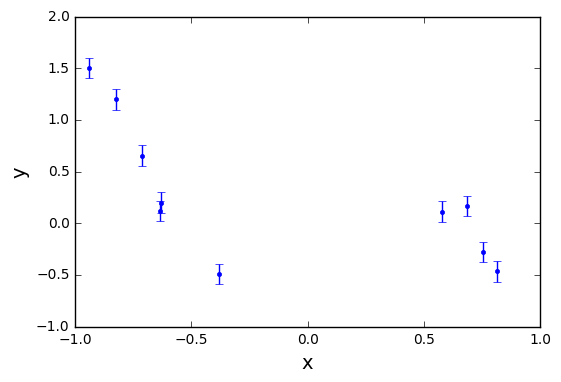

In [41]:
n_points=10
x_complex = np.zeros(n_points)
y_complex = np.zeros(n_points)
y_complex_sigma = np.zeros(n_points)
sigma=0.1
for i in range(0,n_points):
    x_complex[i] = random.uniform(-1,1)
    y_complex[i] = model_complex(x_complex[i],params)+random.gauss(0,sigma)
    y_complex_sigma[i] = sigma

# make sure figures appear inline in Ipython Notebook
%matplotlib inline
plt.subplot(1,1,1)

h0 = plt.errorbar(x_complex,y_complex,yerr=y_complex_sigma,linestyle='None',marker='.')

plt.ylabel('y',fontsize=lab_fontsize)
plt.xlabel('x',fontsize=lab_fontsize)

We can use a [WhiteKernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.WhiteKernel.html) with a constant noise specified by the error, to add an extra variance term to the kernel. In the scikit-learn package however, this is easily spcified using the *alpha* parameter.

In [42]:
kernel = kernels.RBF(length_scale=2.0, length_scale_bounds=(0.1, 10.0))

gp = GaussianProcessRegressor(kernel=kernel,alpha=y_complex_sigma**2)

xprime = np.atleast_2d(x_complex).T
yprime = np.atleast_2d(y_complex).T
gp.fit(xprime, yprime)
xplot_prime = np.atleast_2d(x_out_complex).T
y_pred, sigma = gp.predict(x_out_complex[:, np.newaxis], return_std=True)

y_pred = y_pred.flatten()

Once again we can plot the outcome

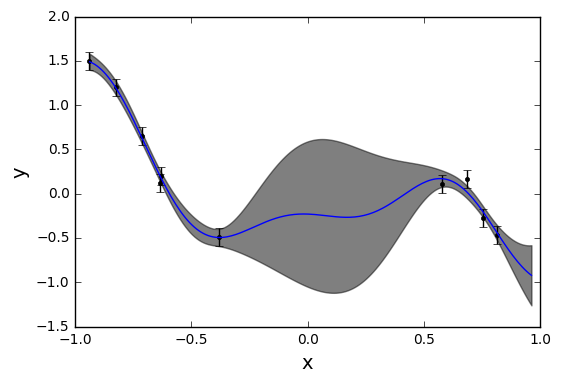

In [43]:
# make sure figures appear inline in Ipython Notebook
%matplotlib inline
ax = plt.subplot(1,1,1)

h0 = plt.errorbar(x_complex,y_complex,yerr=y_complex_sigma,linestyle='None',marker='.',color='black')
h1 = plt.plot(x_out_complex,y_pred,label='gaussian process')
plt.fill_between(x_out_complex, y_pred - sigma, y_pred + sigma,alpha=0.5, color='k')

plt.ylabel('y',fontsize=lab_fontsize)
plt.xlabel('x',fontsize=lab_fontsize)

As you can see, this widens the prediction region around the data points, bringing it in line with the variance of the data. The region where we do not have very much data (here the region $-0.3<x<0.5$) has a very wide confidence region.

### Gaussian Process Classification

We can also use Gaussian processes for the purpose of classification. It will extrapolate on the basis of a feature, and return a probability of belonging to a certain class.

As an example, I downloaded my freinds list from Facebook, and classified all the gender binary members of the list into male and female. Then I stripped all information but the final letter of the first name. Can we classify gender based on this feature? 

105
166


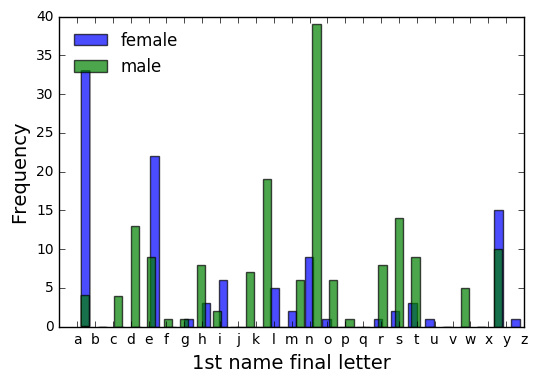

In [60]:
import csv
from itertools import compress
import operator 
final_letter_first_name = []
final_letter_last_name = []
gender_list = []

with open('facebook_data_anonymous.csv','rb') as csv_file:
    rowreader = csv.reader(csv_file, delimiter=' ')
    for row in rowreader:
        final_letter_first_name.append(ord(row[0])-96)
        final_letter_last_name.append(ord(row[1])-96)
        if row[2] == 'M':
            gender_list.append(0)
        else:
            gender_list.append(1)
        
%matplotlib inline
female_final_letter = list(compress(final_letter_first_name,gender_list))
print len(female_final_letter)
inverted_gender_list = map(operator.not_,gender_list)
male_final_letter = list(compress(final_letter_first_name,inverted_gender_list))
print len(male_final_letter)
gender_list = np.array(gender_list, dtype=np.float32)
lab_fontsize = 14
ax = plt.subplot(1,1,1)
n,bins, patches  = plt.hist(female_final_letter,26,histtype='bar',alpha=0.7,label='female',rwidth=0.5)
n,bins, patches  = plt.hist(male_final_letter,26,histtype='bar',alpha=0.7,label='male',rwidth=0.5)
plt.xlabel('1st name final letter',fontsize=lab_fontsize)
plt.xlim(0,26)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles,frameon=False,loc=2)
#plt.yticks([0,1],['Male','Female'])
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26],
           ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o',
           'p','q','r','s','t','u','v','w','x','y','z'])
plt.ylabel('Frequency',fontsize=lab_fontsize)

Firstly I will divide my sample into a training set and a test set (75% training and 25% test)

In [61]:
n = len(final_letter_first_name)
train_size = int(np.ceil(0.75*np.float(n)))
test_size = n - train_size
#create training set
first_name_train_set = final_letter_first_name[:train_size]
gender_train_set = gender_list[:train_size]
#create test set
first_name_test_set = final_letter_first_name[train_size:]
gender_test_set = gender_list[train_size:]
#check size of test set
if test_size!=len(first_name_test_set):
    print "Test set not expected size"

Now I will try to classify

In [62]:
from sklearn.gaussian_process import GaussianProcessClassifier, kernels

kernel = kernels.RBF(length_scale=2.0, length_scale_bounds=(0.1, 10.0))

first_name_train_set = np.array(first_name_train_set)
gender_train_set = np.array(gender_train_set)

fnts_prime = np.atleast_2d(first_name_train_set).T
gl_prime = np.atleast_2d(gender_train_set).T

clf = GaussianProcessClassifier(kernel=kernel, warm_start=True).fit(fnts_prime, gl_prime)

/Users/uqdpark7/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Now I run a prediction for my test set

In [63]:
first_name_test_set = np.array(first_name_test_set)

fn_test_prime = np.atleast_2d(first_name_test_set).T

Z = clf.predict(fn_test_prime)

Now I see what the outcome was for each

In [64]:
failure = 0
success = 0

for i_letter in range(0,test_size):
    s= str(chr(int(first_name_test_set[i_letter]+96)))
    if Z[i_letter]:
        if gender_test_set[i_letter]:
#            print "Final letter of first name %s prediction is female, actual is female, sucess"%(s)
            success += 1
        else: 
#            print "Final letter of first name %s prediction is female, actual is male, failure"%(s)
            failure += 1
    else:
        if gender_test_set[i_letter]:
#            print "Final letter of first name %s prediction is male, actual is female, failure"%(s)
            failure += 1
        else:
#            print "Final letter of first name %s prediction is male, actual is male, success"%(s)
            success += 1

Now I can print out my success and failure statistics

In [65]:
print "Success rate for first name predictions = %f"%(np.float(success)/np.float(success+failure))

Success rate for first name predictions = 0.731343


73% isn't a great accuracy for a classification scheme, and I probably need a larger training set to get better accuracy.